In [2]:
# Imports from __future__ in case we're running Python 2
from __future__ import division, print_function
from __future__ import absolute_import, unicode_literals

# Our numerical workhorses
import scipy as sp
import numpy as np
import scipy.ndimage
import scipy.integrate
import scipy.optimize
import scipy.stats
import pandas as pd
import emcee
#import MCMC_utils_emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def lnlike(theta, x, y, yerr):
    """
    
    Parameters
    ----------
    KA : inducer binding affinities for the repressor in the active state 
    KI : inducer binding affinities for the repressor in the inactive state 
    R : [R]/K_DNA term
    betaeps : exp(-beta epsilon) term
    
    
    Returns
    -------
    output : float
        Log likelihood 
    """
    KA, KI, R, betaeps = theta
    Freg = (1 + x*(10**-3)/KA)**2 / ((1 + x*(10**-3)/KA)**2 + betaeps*(1 + x*(10**-3)/KI)**2)
    model = 1.00/(1.00 + (R)*Freg) 
    
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [4]:
def lnprior(theta):
    return 0
    KA, KI, R, betaeps = theta
    if 0.00 < KA < 1.00 and 0.00 < KI < 1.00 and 0.00 < R < 1000000.00 and 0.00 < betaeps < 2000.00:
        return 0.0
    return -np.inf

In [5]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [6]:
#load data
df = pd.read_csv('wildtypedata.csv')
x = df['c']
y = df['foldchange']
yerr = df['error']

In [7]:
# Specify paremeters for emcee
n_dim = 4                    # number of parameters in the model
n_walkers = 4*(n_dim)        # number of MCMC walkers
n_burn = 300                # "burn-in" period to let chains stabilize
n_steps = 500              # number of MCMC steps to take after burn-in
#n_temp = 20               # number of temperatures
# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(10.0**-7, 10.0**-4, n_walkers)          # KA
p0[:,1] = np.random.uniform(10.0**-7, 10.0**-4, n_walkers)           #KI
p0[:,2] = np.random.uniform(0.0, 999999.0, n_walkers)                  # [R]/K_DNA
p0[:,3] = np.random.uniform(0.0, 1999.9, n_walkers)                   # exp epsilon term





In [26]:
#sampler.reset()

In [8]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnprob, args=(x, y, yerr))

In [9]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [10]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [12]:
samples = sampler.chain[:, :, :].reshape((-1, n_dim))

In [11]:
#avg KA - epsli 0-2 = 1.6223529976259086e-05
samples[100000:,0].mean()

1.6791800418092723e-05

In [12]:
#avg KI - epsli 0-2 = 1.4104301471989867e-06
samples[100000:,1].mean()

1.7701079646203482e-06

In [29]:
#avg R/K_DNA WT - epsil 0-2 = 58.2137921287
print(samples[70000:130000,2].mean())
print(samples[70000:130000,2].std())

34872.318073
13174.6458793


In [27]:
#avg exp(-beta epsilon) epsi 0-2 = 1.3190996139240598
samples[70000:130000,3].mean()

1334.3232180212276

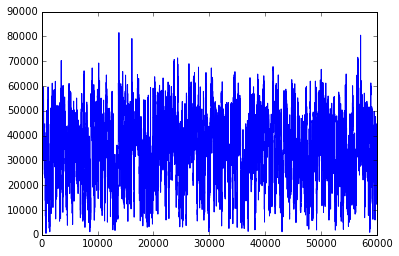

In [25]:
plt.plot(samples[70000:130000,2])

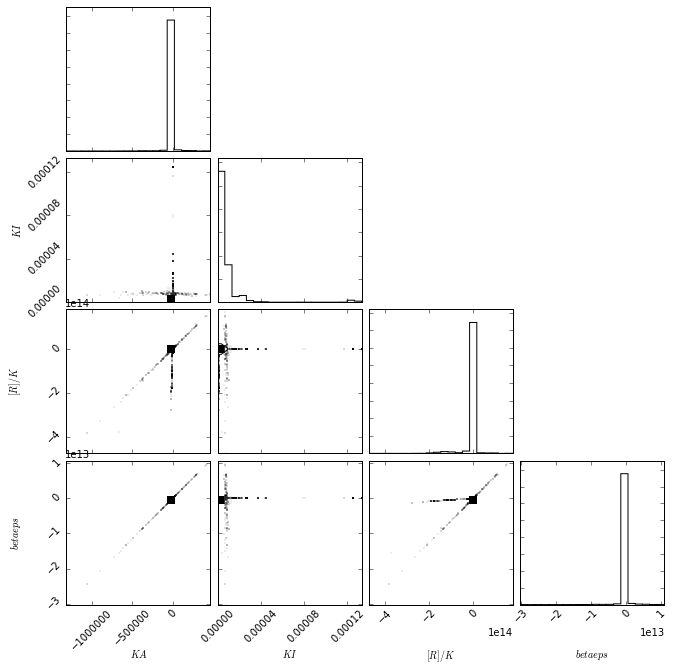

In [13]:
import corner
fig = corner.corner(samples[:,0:4], labels=["$KA$", "$KI$", "$[R]/K$", "$betaeps$"])#, "$\ln\,f$"])

In [22]:
#export 'samples' data
np.savetxt('MCMC_lac_wt_nolnF.csv',samples)

In [3]:
#samples = np.loadtxt('MCMC_wt.csv')

200000